In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

#Evaluating models
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, auc,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings('ignore')

In [4]:
# 1 Load Data
df=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/BankChurners.csv')
df=df.replace('Unknown',np.NaN)

# 2 Drop Unnecessary columns
df=df.drop(axis=1,columns=['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
display(df.head())

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


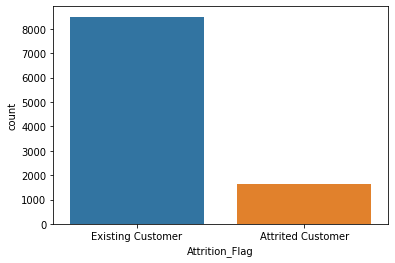

In [5]:
# Imbalanced y
sns.countplot(df['Attrition_Flag'])

## Original Dataset

In [88]:
# Set X & y
X, y = df.iloc[:,1:],df.iloc[:,0]
y = y.apply(lambda x:(x=='Attrited Customer')*1)
X.fillna(0,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2048, stratify=y)

In [89]:
num_attri_lst=make_column_selector(dtype_exclude=object)(X_train)
cat_attri_lst=make_column_selector(dtype_include=object)(X_train)

In [90]:
# Get dummy
def get_dummy(df):
  # Get dummies
  dummied_data=df
  for i in df.columns:
    dummy_df=pd.get_dummies(df[i],prefix=i)
    dummied_data=pd.concat([dummied_data,dummy_df],axis=1)
  dummied_data.drop(axis=1,inplace=True,columns=df.columns)
  return dummied_data

In [91]:
train_X_dummy=get_dummy(X_train[cat_attri_lst])

test_X_dummy=get_dummy(X_test[cat_attri_lst])

In [92]:
scaler = StandardScaler()

X_train_scaled = pd.concat([pd.DataFrame(scaler.fit_transform(X_train[num_attri_lst])).reset_index(drop=True),train_X_dummy.reset_index(drop=True)],axis=1,ignore_index=True)
X_train_scaled.columns=num_attri_lst+train_X_dummy.columns.to_list()

X_test_scaled = pd.concat([pd.DataFrame(scaler.transform(X_test[num_attri_lst])).reset_index(drop=True),test_X_dummy.reset_index(drop=True)],axis=1,ignore_index=True)
X_test_scaled.columns=num_attri_lst+test_X_dummy.columns.to_list()


In [93]:
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression

def resample(A_train_scaled,A_test_scaled):
  # SMOTENC
  cat_col_idx = [A_train_scaled.columns.to_list().index(i) for i in A_train_scaled.columns.to_list() if i in train_X_dummy.columns]

  ratios = [0.2, 0.4, 0.6, 0.8, 1]
  score=[]

  clf = LogisticRegression(max_iter=1000,random_state=2048)
  clf.fit(A_train_scaled, y_train)
  score.append(clf.score(A_test_scaled,y_test))

  for n, ratio in enumerate(ratios):
    smo = SMOTENC(cat_col_idx,sampling_strategy=ratio, random_state=2048)
    X_resample, y_resample = smo.fit_resample(A_train_scaled, y_train)
    clf.fit(X_resample, y_resample)
    score.append(clf.score(A_test_scaled,y_test))

  best_ratio=ratios[score.index(max(score))]

  plt.plot([0]+ratios,score)
  plt.show()
  return cat_col_idx,best_ratio

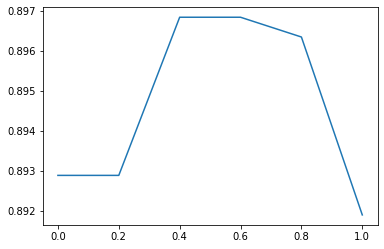

In [94]:
cat_col_idx,best_ratio=resample(X_train_scaled,X_test_scaled)

In [95]:
smo = SMOTENC(cat_col_idx,sampling_strategy=best_ratio, random_state=2048)
X_resample, y_resample = smo.fit_resample(X_train_scaled, y_train)

#### Logistic

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best score:  0.9672128284598305
best params:  {'C': 1, 'penalty': 'l2'}
Logistic Regression Test Accuracy is 0.8973346495557749
Logistic Regression AUC on test set: 0.920
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1701
           1       0.69      0.64      0.67       325

    accuracy                           0.90      2026
   macro avg       0.81      0.79      0.80      2026
weighted avg       0.89      0.90      0.90      2026



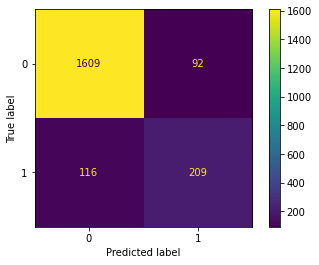

In [14]:
logistic_clf = LogisticRegression(random_state=42)
param_grid = {'penalty':['l2','l1'],
        'C':[0.01,0.1,0.5,1]}
grid = GridSearchCV(logistic_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_logistic = grid_result.predict(X_test_scaled)
print('Logistic Regression Test Accuracy is {}'.format(accuracy_score(y_test, pred_logistic)))
print("Logistic Regression AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_logistic))
logistic_cm = confusion_matrix(y_test, pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=logistic_cm)
disp.plot()
plt.show()

#### XGBoost

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best score:  0.9960381840768218
best params:  {'min_child_weight': 1, 'n_estimators': 200}
XGBoost Test Accuracy is 0.9669299111549852
XGBoost AUC on test set: 0.991
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.89      0.90      0.90       325

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026



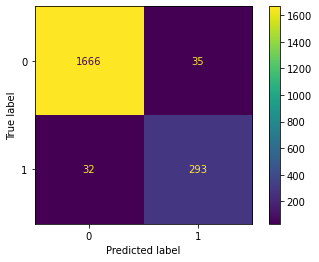

In [15]:
xgboost_clf = XGBClassifier(objective='binary:logistic', eval_metric="auc", n_jobs=-1 ,random_state=42)
param_grid = {'n_estimators':[100, 150, 200],
        'min_child_weight':[0.5, 1, 2]
        }
grid = GridSearchCV(xgboost_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_xgboost = grid_result.predict(X_test_scaled)
print('XGBoost Test Accuracy is {}'.format(accuracy_score(y_test, pred_xgboost)))
print("XGBoost AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_xgboost))
xgboost_cm = confusion_matrix(y_test, pred_xgboost)
disp = ConfusionMatrixDisplay(confusion_matrix=xgboost_cm)
disp.plot()
plt.show()

#### LightGBM

Fitting 5 folds for each of 27 candidates, totalling 135 fits
best score:  0.9973237909976385
best params:  {'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 50}
LightGBM Test Accuracy is 0.9679170779861797
LightGBM AUC on test set: 0.991
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.91      0.89      0.90       325

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026



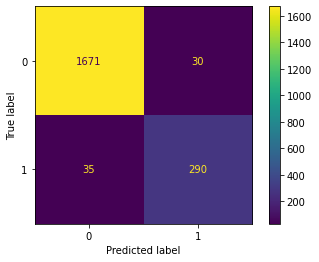

In [96]:
lightgbm_clf = LGBMClassifier(objective = 'binary', metric = 'binary_logloss,auc',random_state=42)

param_grid = {'max_depth': [4, 6, 8],
        'num_leaves':[30, 40, 50],
        'learning_rate': [0.01, 0.05, 0.1],
        }

grid = GridSearchCV(lightgbm_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_lightgbm = grid_result.predict(X_test_scaled)
print('LightGBM Test Accuracy is {}'.format(accuracy_score(y_test, pred_lightgbm)))
print("LightGBM AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_lightgbm))
lightgbm_cm = confusion_matrix(y_test, pred_lightgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=lightgbm_cm)
disp.plot()
plt.show()

##### Feature Importance

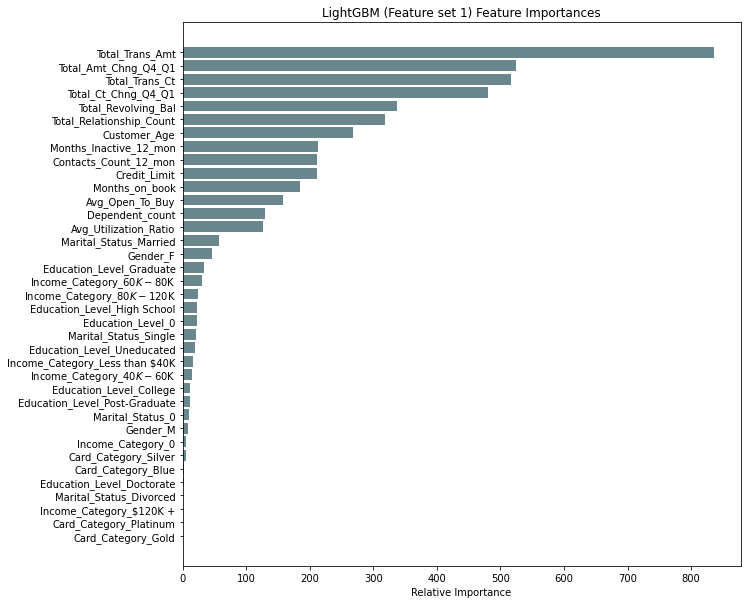

In [97]:
lightgbm_clf = LGBMClassifier(objective = 'binary', metric = 'binary_logloss,auc',random_state=42, learning_rate=0.1, max_depth=8, num_leaves=50)
lightgbm_clf.fit(X_resample, y_resample)
importances = lightgbm_clf.feature_importances_
indices = np.argsort(importances)
features = X_resample.columns.values
lgb_auc = roc_auc_score(y_test,lightgbm_clf.predict_proba(X_test_scaled)[:,1])
plt.figure(figsize=(10,10))
plt.title('LightGBM (Feature set 1) Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#6B878E', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##### Permutation Feature Importance

,pred,score
3,Total_Relationship_Count,-0.011056
10,Total_Trans_Amt,-0.080251
11,Total_Trans_Ct,-0.241208


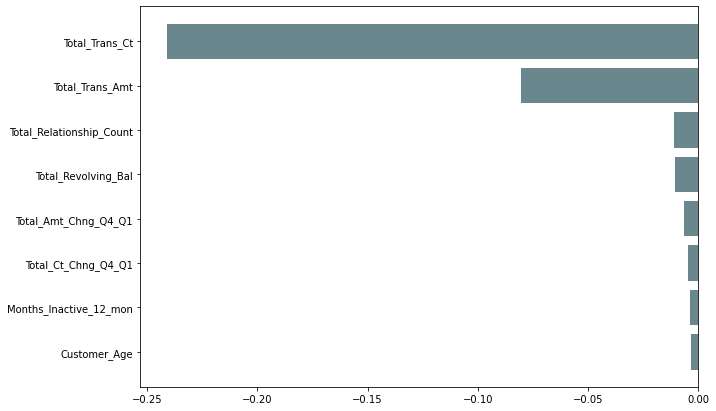

In [98]:
# Initialize a list of results
results = []
# Iterate through each predictor
for predictor in X_test_scaled:
    
    # Create a copy of X_test
    X_test_copy = X_test_scaled.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[predictor] = X_test_scaled[predictor].sample(frac=1).values
    
    # Calculate the new RMSE
    new_auc = roc_auc_score(y_test,lightgbm_clf.predict_proba(X_test_copy)[:,1])
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor, 'score': new_auc - lgb_auc})
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score', ascending = False)
display(resultsdf.tail(3))
X_pfi = resultsdf.pred.iloc[-8:]
y_pfi = resultsdf.score.iloc[-8:]
plt.figure(figsize=(10,7))
plt.barh(X_pfi,y_pfi, color='#6B878E')
plt.show()

##### LIME

In [99]:
#!pip install lime 
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X_test_scaled.values, feature_names=X_test_scaled.columns.values.tolist(),
                          class_names=['Existing','Attrited'], verbose=True, mode='classification')

# Choose the jth instance and use it to predict the results for that selection
j = 1
exp = explainer.explain_instance(X_test_scaled.values[j], lightgbm_clf.predict_proba, num_features=5)

# Show the predictions
exp.show_in_notebook(show_table=True)

Intercept 0.34514423794035665
Prediction_local [0.26982877]
Right: 0.0003433162752892935


#### Random Forest

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best score:  0.996254863640673
best params:  {'max_samples': 0.9, 'n_estimators': 200}
random forest Test Accuracy is 0.9555774925962488
random forest AUC on test set: 0.983
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1701
           1       0.87      0.85      0.86       325

    accuracy                           0.96      2026
   macro avg       0.92      0.91      0.92      2026
weighted avg       0.96      0.96      0.96      2026



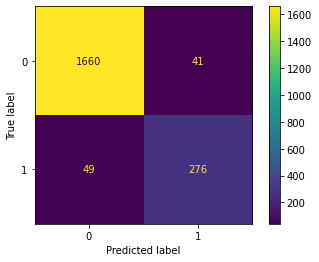

In [100]:
rf_clf = RandomForestClassifier(n_estimators=200, max_features='auto', criterion='entropy', bootstrap=True, random_state=42,)
param_grid = {'n_estimators':[100, 150, 200],
      'max_samples':[0.1, 0.5, 0.9]
      }
grid = GridSearchCV(rf_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_rf = grid_result.predict(X_test_scaled)
print('random forest Test Accuracy is {}'.format(accuracy_score(y_test, pred_rf)))
print("random forest AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_rf))
rf_cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
disp.plot()
plt.show()

#### Deep Learning

In [101]:
# 用X_resample, y_resample跑模型
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.optimizers import schedules, Adam
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Dense
from keras.models import Sequential

In [102]:
set_random_seed(2048)

NNmodel = Sequential()
NNmodel.add(Dense(units=10, activation='relu', use_bias=True,input_shape=(X_resample.shape[1],)))
NNmodel.add(Dropout(0.3))
NNmodel.add(Dense(1, activation='sigmoid'))

scheduler = schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,
    decay_rate=0.9)
optimizer = Adam(learning_rate=scheduler)
es = EarlyStopping(monitor='val_acc', mode='max', patience=20, verbose=1)
NNmodel.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[tf.keras.metrics.AUC(from_logits=True)])
NNmodel.fit(X_resample,y_resample,batch_size=256, epochs=100, validation_split=0.2, verbose=1, callbacks=[es])

Epoch 1/100
34/34 [==============================] - 2s 18ms/step - loss: 0.3465 - auc_3: 0.8774 - val_loss: 0.4816 - val_auc_3: 0.0000e+00
Epoch 2/100
34/34 [==============================] - 0s 4ms/step - loss: 0.2673 - auc_3: 0.9311 - val_loss: 0.3181 - val_auc_3: 0.0000e+00
Epoch 3/100
34/34 [==============================] - 0s 4ms/step - loss: 0.2445 - auc_3: 0.9426 - val_loss: 0.3023 - val_auc_3: 0.0000e+00
Epoch 4/100
34/34 [==============================] - 0s 4ms/step - loss: 0.2382 - auc_3: 0.9450 - val_loss: 0.3563 - val_auc_3: 0.0000e+00
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss: 0.2350 - auc_3: 0.9468 - val_loss: 0.2525 - val_auc_3: 0.0000e+00
Epoch 6/100
34/34 [==============================] - 0s 4ms/step - loss: 0.2263 - auc_3: 0.9515 - val_loss: 0.3353 - val_auc_3: 0.0000e+00
Epoch 7/100
34/34 [==============================] - 0s 7ms/step - loss: 0.2337 - auc_3: 0.9486 - val_loss: 0.2544 - val_auc_3: 0.0000e+00
Epoch 8/100
34/34 [=======

In [103]:
y_pred=NNmodel.predict(X_test_scaled)

lst=[]
for i,v in enumerate(y_pred):
  lst.append(int(round(v[0])))
  
y_pred=lst
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1743
           1       0.71      0.81      0.76       283

    accuracy                           0.93      2026
   macro avg       0.84      0.88      0.86      2026
weighted avg       0.93      0.93      0.93      2026



## Create new features

In [27]:
# Set X & y
X, y = df.iloc[:,1:],df.iloc[:,0]
y = y.apply(lambda x:(x=='Attrited Customer')*1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2048, stratify=y)

In [28]:
# feature engineering
def obtain_new_col(X):
  X['Avg_Trans_Amt']=X['Total_Trans_Amt']/X['Total_Trans_Ct']
  X['Avg_Change']=X['Total_Amt_Chng_Q4_Q1']/X['Total_Ct_Chng_Q4_Q1']
  X['Months_active']=12-X['Months_Inactive_12_mon']
  X['Avg_Contacts_Cnt']=X['Contacts_Count_12_mon']/X['Months_active']
  X['Gender_Marital']=X['Gender']+'_'+X['Marital_Status']
  
  X.drop(['Total_Trans_Amt','Total_Amt_Chng_Q4_Q1','Months_Inactive_12_mon','Contacts_Count_12_mon','Gender','Marital_Status'],axis=1,inplace=True)

  X.replace(np.inf,0,inplace=True)
  X.fillna(0,inplace=True)

  return X

In [29]:
X_train = obtain_new_col(X_train)
X_test = obtain_new_col(X_test)

In [30]:
num_attri_lst=make_column_selector(dtype_exclude=object)(X_train)
cat_attri_lst=make_column_selector(dtype_include=object)(X_train)

In [31]:
# Dummy
train_X_dummy=get_dummy(X_train[cat_attri_lst])
test_X_dummy=get_dummy(X_test[cat_attri_lst])

In [32]:
# STD scale
scaler = StandardScaler()

X_train_scaled = pd.concat([pd.DataFrame(scaler.fit_transform(X_train[num_attri_lst])).reset_index(drop=True),train_X_dummy.reset_index(drop=True)],axis=1,ignore_index=True)
X_train_scaled.columns=num_attri_lst+train_X_dummy.columns.to_list()

X_test_scaled = pd.concat([pd.DataFrame(scaler.transform(X_test[num_attri_lst])).reset_index(drop=True),test_X_dummy.reset_index(drop=True)],axis=1,ignore_index=True)
X_test_scaled.columns=num_attri_lst+test_X_dummy.columns.to_list()

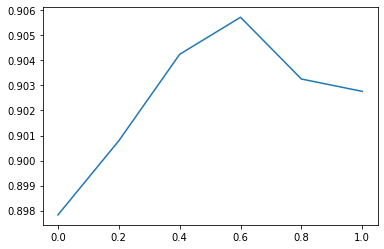

In [33]:
# Resample
cat_col_idx,best_ratio=resample(X_train_scaled,X_test_scaled)
smo = SMOTENC(cat_col_idx,sampling_strategy=best_ratio, random_state=2048)
X_resample, y_resample = smo.fit_resample(X_train_scaled, y_train)

#### Logistic Regression

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best score:  0.9752039342291715
best params:  {'C': 1, 'penalty': 'l2'}
Logistic Regression Test Accuracy is 0.9042448173741362
Logistic Regression AUC on test set: 0.925
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1701
           1       0.70      0.70      0.70       325

    accuracy                           0.90      2026
   macro avg       0.82      0.82      0.82      2026
weighted avg       0.90      0.90      0.90      2026



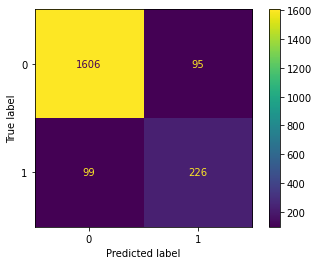

In [34]:
logistic_clf = LogisticRegression(random_state=42)
param_grid = {'penalty':['l2','l1'],
        'C':[0.01,0.1,0.5,1]}
grid = GridSearchCV(logistic_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_logistic = grid_result.predict(X_test_scaled)
print('Logistic Regression Test Accuracy is {}'.format(accuracy_score(y_test, pred_logistic)))
print("Logistic Regression AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_logistic))
logistic_cm = confusion_matrix(y_test, pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=logistic_cm)
disp.plot()
plt.show()

#### XGBoost

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best score:  0.9933860059476938
best params:  {'min_child_weight': 1, 'n_estimators': 200}
XGBoost Test Accuracy is 0.9447186574531096
XGBoost AUC on test set: 0.977
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1701
           1       0.82      0.84      0.83       325

    accuracy                           0.94      2026
   macro avg       0.89      0.90      0.90      2026
weighted avg       0.95      0.94      0.94      2026



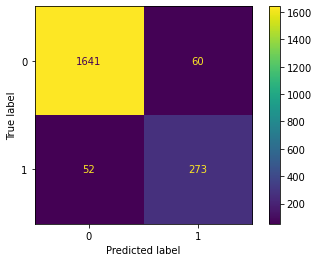

In [35]:
xgboost_clf = XGBClassifier(objective='binary:logistic', eval_metric="auc", n_jobs=-1 ,random_state=42)
param_grid = {'n_estimators':[100, 150, 200],
        'min_child_weight':[0.5, 1, 2]
        }
grid = GridSearchCV(xgboost_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_xgboost = grid_result.predict(X_test_scaled)
print('XGBoost Test Accuracy is {}'.format(accuracy_score(y_test, pred_xgboost)))
print("XGBoost AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_xgboost))
xgboost_cm = confusion_matrix(y_test, pred_xgboost)
disp = ConfusionMatrixDisplay(confusion_matrix=xgboost_cm)
disp.plot()
plt.show()

#### LightGBM

Fitting 5 folds for each of 27 candidates, totalling 135 fits
best score:  0.9969960027311439
best params:  {'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 50}
LightGBM Test Accuracy is 0.9516288252714709
LightGBM AUC on test set: 0.986
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1701
           1       0.85      0.85      0.85       325

    accuracy                           0.95      2026
   macro avg       0.91      0.91      0.91      2026
weighted avg       0.95      0.95      0.95      2026



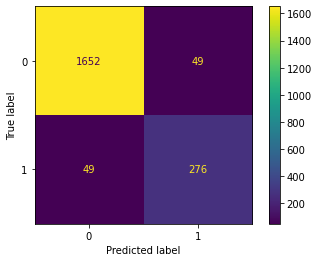

In [36]:
lightgbm_clf = LGBMClassifier(objective = 'binary', metric = 'binary_logloss,auc',random_state=42)

param_grid = {'max_depth': [4, 6, 8],
        'num_leaves':[30, 40, 50],
        'learning_rate': [0.01, 0.05, 0.1],
        }

grid = GridSearchCV(lightgbm_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_lightgbm = grid_result.predict(X_test_scaled)
print('LightGBM Test Accuracy is {}'.format(accuracy_score(y_test, pred_lightgbm)))
print("LightGBM AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_lightgbm))
lightgbm_cm = confusion_matrix(y_test, pred_lightgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=lightgbm_cm)
disp.plot()
plt.show()

##### Feature Importance

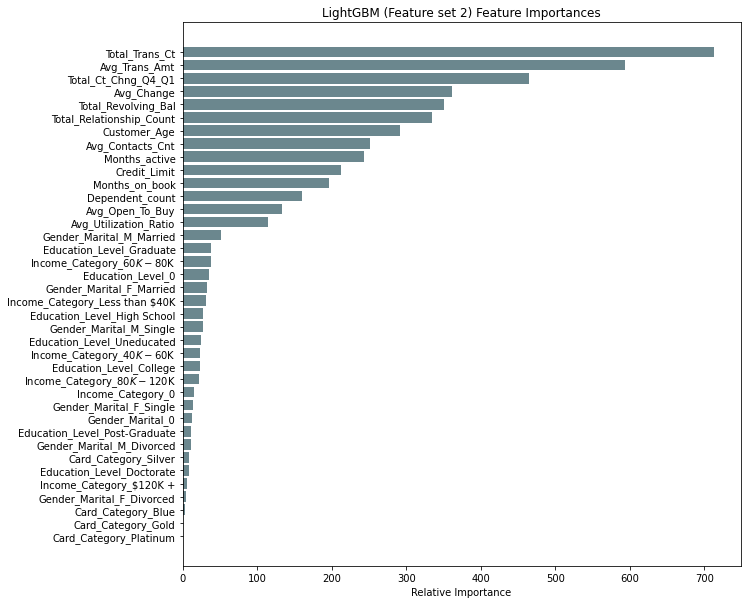

In [37]:
lightgbm_clf = LGBMClassifier(objective = 'binary', metric = 'binary_logloss,auc',random_state=42, learning_rate=0.1, max_depth=8, num_leaves=50)
lightgbm_clf.fit(X_resample, y_resample)
importances = lightgbm_clf.feature_importances_
indices = np.argsort(importances)
features = X_resample.columns.values
lgb_auc = roc_auc_score(y_test,lightgbm_clf.predict_proba(X_test_scaled)[:,1])
plt.figure(figsize=(10,10))
plt.title('LightGBM (Feature set 2) Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#6B878E', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##### Permutation Feature Importance

,pred,score
8,Total_Ct_Chng_Q4_Q1,-0.022409
10,Avg_Trans_Amt,-0.060784
7,Total_Trans_Ct,-0.256166


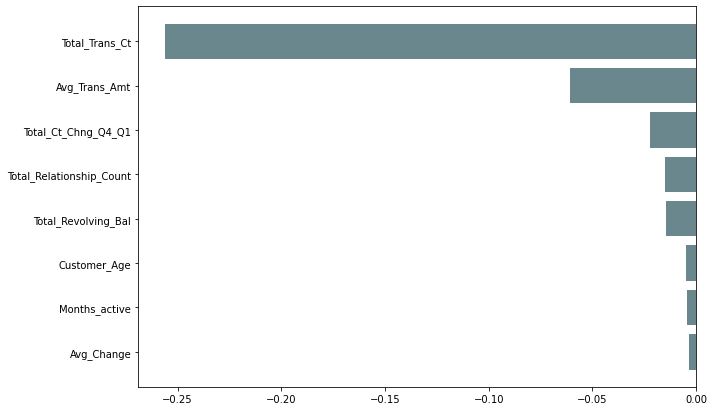

In [38]:
# Initialize a list of results
results = []
# Iterate through each predictor
for predictor in X_test_scaled:
    
    # Create a copy of X_test
    X_test_copy = X_test_scaled.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[predictor] = X_test_scaled[predictor].sample(frac=1).values
    
    # Calculate the new RMSE
    new_auc = roc_auc_score(y_test,lightgbm_clf.predict_proba(X_test_copy)[:,1])
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor, 'score': new_auc - lgb_auc})
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score', ascending = False)
display(resultsdf.tail(3))
X = resultsdf.pred.iloc[-8:]
y = resultsdf.score.iloc[-8:]
plt.figure(figsize=(10,7))
plt.barh(X,y, color='#6B878E')
plt.show()

#### Random Forest

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best score:  0.9956522343305358
best params:  {'max_samples': 0.9, 'n_estimators': 200}
random forest Test Accuracy is 0.9447186574531096
random forest AUC on test set: 0.972
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1701
           1       0.84      0.81      0.82       325

    accuracy                           0.94      2026
   macro avg       0.90      0.89      0.90      2026
weighted avg       0.94      0.94      0.94      2026



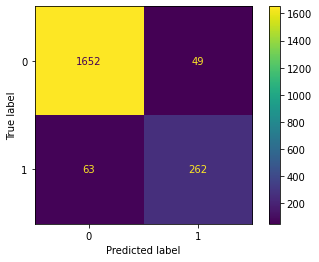

In [39]:
rf_clf = RandomForestClassifier(n_estimators=200, max_features='auto', criterion='entropy', bootstrap=True, random_state=42,)
param_grid = {'n_estimators':[100, 150, 200],
      'max_samples':[0.1, 0.5, 0.9]
      }
grid = GridSearchCV(rf_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_rf = grid_result.predict(X_test_scaled)
print('random forest Test Accuracy is {}'.format(accuracy_score(y_test, pred_rf)))
print("random forest AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_rf))
rf_cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
disp.plot()
plt.show()

#### Stacking

Level 0: Logistic Regression, LightGBM, XGBoost <br>
Level 1: LightGBM

In [40]:
# Defining our estimator, the algorithm to optimize
models_to_train = [LogisticRegression(), 
          LGBMClassifier(objective = 'binary', metric = 'binary_logloss,auc',random_state=42),
          XGBClassifier(objective='binary:logistic', eval_metric="auc", n_jobs=-1 ,random_state=42)]
# Defining the hyperparameters to optimize
# pay attention how later we define a function and array so we can do grid search

grid_parameters = [
    { # logistic regression
        'solver': ['liblinear'],
        'penalty': ['l2'],
        'C': [100, 10, 1.0, 0.1, 0.01],
        'max_iter':[1000] # if you use default value, you may receive convergence warning messages
    }, 
    { # LightGBM
        'max_depth': [4, 6, 8],
        'num_leaves':[30, 40, 50],
        'learning_rate': [0.01, 0.05, 0.1]
    }, 
    
    { # XGBoost
        'n_estimators':[100, 150, 200],
        'min_child_weight':[0.5, 1, 2]
    },
]

In [41]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
            model, param_grid, cv=5, scoring_fit='accuracy',
            scoring_test=accuracy_score):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        scoring=scoring_fit,
        verbose=1
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    best_model = fitted_model.best_estimator_
    pred = fitted_model.predict(X_test_data)
    score = scoring_test(y_test_data, pred) # this may needs to be fixed, not linking to scoring=scoring_fit
    
    return [best_model, pred, score]

In [42]:
models_preds_scores = []

for i, model in enumerate(models_to_train):
    params = grid_parameters[i]
    
    result = algorithm_pipeline(X_resample, X_test_scaled, y_resample, y_test, model, params, cv=5)
    models_preds_scores.append(result)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [43]:
for result in models_preds_scores:
    print('Model: {0}, Score: {1}'.format(result[0], result[2]))

Model: LogisticRegression(C=100, max_iter=1000, solver='liblinear'), Score: 0.903751233958539
Model: LGBMClassifier(max_depth=8, metric='binary_logloss,auc', num_leaves=50,
               objective='binary', random_state=42), Score: 0.9516288252714709
Model: XGBClassifier(eval_metric='auc', n_estimators=200, n_jobs=-1, random_state=42), Score: 0.9447186574531096


In [44]:
# The following parameters should be based on your grid search results
logistic_regression = LogisticRegression(C=100, max_iter=1000, solver='liblinear')
lightgbm_classifier = LGBMClassifier(objective = 'binary', metric = 'binary_logloss,auc', max_depth=6, num_leaves=30, random_state=42)
xgboost_classifier = XGBClassifier(objective='binary:logistic', eval_metric="auc", min_child_weight=0.5, n_estimators=200, n_jobs=-1 ,random_state=42)

Stacking Test Accuracy is 0.9555774925962488
Stacking AUC on test set: 0.972
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1701
           1       0.86      0.86      0.86       325

    accuracy                           0.96      2026
   macro avg       0.92      0.92      0.92      2026
weighted avg       0.96      0.96      0.96      2026



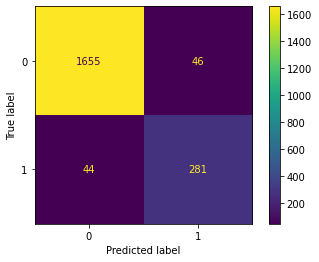

In [45]:
# define a stacking ensemble of models
def get_model():
    # define the level-0 base models with tuned paramters
    level0 = []
    level0.append(('lr', logistic_regression))
    level0.append(('lightgbm', lightgbm_classifier))
    level0.append(('xgboost', xgboost_classifier))
    # define level-1 meta learner model
    level1 = LGBMClassifier(objective = 'binary', metric = 'binary_logloss,auc', random_state=42)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1)
    return model

# get the stacking model
stacking_model = get_model()
# evaluate its performance
stack = stacking_model.fit(X_resample, y_resample)
# evaluate the model
y_pred = stack.predict(X_test_scaled)
print('Stacking Test Accuracy is {}'.format(accuracy_score(y_test, y_pred)))
print("Stacking AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, y_pred))
stack_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=stack_cm)
disp.plot()
plt.show()

Level 0: Logistic Regression, KNN, Decision Tree, SVM <br>
Level 1: Logistic Regression

In [46]:
# Defining our estimator, the algorithm to optimize
models_to_train = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC()]
# Defining the hyperparameters to optimize
# pay attention how later we define a function and array so we can do grid search

grid_parameters = [
    { # logistic regression
        'solver': ['liblinear'],
        'penalty': ['l2'],
        'C': [100, 10, 1.0, 0.1, 0.01],
        'max_iter':[1000] # if you use default value, you may receive convergence warning messages
    }, 
    { # KNN
        'n_neighbors': list(range(1, 10, 1))
    }, 
    
    { # Tree
        'criterion': ['gini', 'entropy'],
        'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12]
    },
    { # SVC
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'C': [50, 10, 1.0, 0.1, 0.01],
        'gamma': ['scale']
    },
]

In [47]:
models_preds_scores = []

for i, model in enumerate(models_to_train):
    params = grid_parameters[i]
    
    result = algorithm_pipeline(X_resample, X_test_scaled, y_resample, y_test, model, params, cv=5)
    models_preds_scores.append(result)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [48]:
for result in models_preds_scores:
    print('Model: {0}, Score: {1}'.format(result[0], result[2]))

Model: LogisticRegression(C=100, max_iter=1000, solver='liblinear'), Score: 0.903751233958539
Model: KNeighborsClassifier(n_neighbors=2), Score: 0.8968410661401777
Model: DecisionTreeClassifier(criterion='entropy', max_depth=10), Score: 0.9215202369200395
Model: SVC(C=10), Score: 0.9343534057255676


In [49]:
# The following parameters should be based on your grid search results
logistic_regression = LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
knn_classifier = KNeighborsClassifier(leaf_size=1, n_neighbors=9, p=1)
tree_classifier = DecisionTreeClassifier(max_depth=8, random_state=42)
svc = SVC(C=50)

Stacking Test Accuracy is 0.9318854886475815
Stacking AUC on test set: 0.972
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1701
           1       0.81      0.75      0.78       325

    accuracy                           0.93      2026
   macro avg       0.88      0.86      0.87      2026
weighted avg       0.93      0.93      0.93      2026



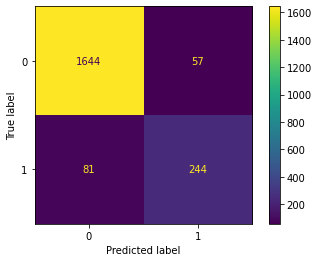

In [50]:
# define a stacking ensemble of models
def get_model():
    # define the level-0 base models with tuned paramters
    level0 = []
    level0.append(('lr', logistic_regression))
    level0.append(('knn', knn_classifier))
    level0.append(('cart', tree_classifier))
    level0.append(('svm', svc))
    # define level-1 meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1)
    return model

# get the stacking model
stacking_model = get_model()
# evaluate its performance
stack = stacking_model.fit(X_resample, y_resample)
# evaluate the model
y_pred = stack.predict(X_test_scaled)
print('Stacking Test Accuracy is {}'.format(accuracy_score(y_test, y_pred)))
print("Stacking AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, y_pred))
stack_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=stack_cm)
disp.plot()
plt.show()

#### Deep Learning

In [51]:
NNmodel2 = Sequential()
NNmodel2.add(Dense(units=10, activation='relu', use_bias=True,input_shape=(X_resample.shape[1],)))
NNmodel2.add(Dropout(0.3))
NNmodel2.add(Dense(1, activation='sigmoid'))


scheduler = schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,
    decay_rate=0.9)
optimizer = Adam(learning_rate=scheduler)
es = EarlyStopping(monitor='val_acc', mode='max', patience=20, verbose=1)
NNmodel2.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[tf.keras.metrics.AUC(from_logits=True)])

NNmodel2.fit(X_resample,y_resample,batch_size=256, epochs=100, validation_split=0.2, verbose=1, callbacks=[es])

Epoch 1/100
39/39 [==============================] - 1s 11ms/step - loss: 0.3106 - auc_1: 0.9284 - val_loss: 0.2258 - val_auc_1: 0.0000e+00
Epoch 2/100
39/39 [==============================] - 0s 3ms/step - loss: 0.2413 - auc_1: 0.9574 - val_loss: 0.1913 - val_auc_1: 0.0000e+00
Epoch 3/100
39/39 [==============================] - 0s 3ms/step - loss: 0.2329 - auc_1: 0.9601 - val_loss: 0.1347 - val_auc_1: 0.0000e+00
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 0.2231 - auc_1: 0.9624 - val_loss: 0.0948 - val_auc_1: 0.0000e+00
Epoch 5/100
39/39 [==============================] - 0s 3ms/step - loss: 0.2196 - auc_1: 0.9632 - val_loss: 0.1322 - val_auc_1: 0.0000e+00
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: 0.2177 - auc_1: 0.9646 - val_loss: 0.1549 - val_auc_1: 0.0000e+00
Epoch 7/100
39/39 [==============================] - 0s 3ms/step - loss: 0.2132 - auc_1: 0.9655 - val_loss: 0.1149 - val_auc_1: 0.0000e+00
Epoch 8/100
39/39 [=======

In [52]:
y_pred=NNmodel2.predict(X_test_scaled)

lst=[]
for i,v in enumerate(y_pred):
  lst.append(int(round(v[0])))
  
y_pred=lst
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1748
           1       0.69      0.80      0.74       278

    accuracy                           0.92      2026
   macro avg       0.83      0.87      0.85      2026
weighted avg       0.93      0.92      0.92      2026



## Dimension reduction (PCA)

In [53]:
# Set X & y
X, y = df.iloc[:,1:],df.iloc[:,0]
y = y.apply(lambda x:(x=='Attrited Customer')*1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2048, stratify=y)

In [54]:
# feature engineering
def obtain_new_col(X):
  X['Avg_Trans_Amt']=X['Total_Trans_Amt']/X['Total_Trans_Ct']
  X['Avg_Change']=X['Total_Amt_Chng_Q4_Q1']/X['Total_Ct_Chng_Q4_Q1']
  X['Month_active']=12-X['Months_Inactive_12_mon']
  X['Avg_Contacts_Cnt']=X['Contacts_Count_12_mon']/X['Month_active']
  X['Gender_Marital']=X['Gender']+'_'+X['Marital_Status']
  
  X.drop(['Total_Trans_Amt','Total_Amt_Chng_Q4_Q1','Months_Inactive_12_mon','Contacts_Count_12_mon','Gender','Marital_Status'],axis=1,inplace=True)

  X.replace(np.inf,0,inplace=True)
  X.fillna(0,inplace=True)

  return X

In [55]:
X_train = obtain_new_col(X_train)
X_test = obtain_new_col(X_test)

In [56]:
num_attri_lst=make_column_selector(dtype_exclude=object)(X_train)
cat_attri_lst=make_column_selector(dtype_include=object)(X_train)

In [57]:
# Dummy
train_X_dummy=get_dummy(X_train[cat_attri_lst])
test_X_dummy=get_dummy(X_test[cat_attri_lst])

In [58]:
# STD scale
scaler = StandardScaler()

X_train_scaled = pd.concat([pd.DataFrame(scaler.fit_transform(X_train[num_attri_lst])).reset_index(drop=True),train_X_dummy.reset_index(drop=True)],axis=1,ignore_index=True)
X_train_scaled.columns=num_attri_lst+train_X_dummy.columns.to_list()

X_test_scaled = pd.concat([pd.DataFrame(scaler.transform(X_test[num_attri_lst])).reset_index(drop=True),test_X_dummy.reset_index(drop=True)],axis=1,ignore_index=True)
X_test_scaled.columns=num_attri_lst+test_X_dummy.columns.to_list()

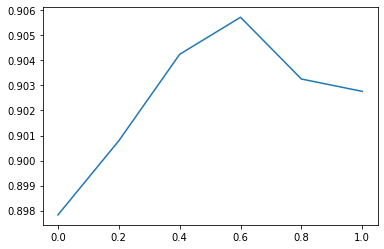

In [59]:
# Resample
cat_col_idx,best_ratio=resample(X_train_scaled,X_test_scaled)
smo = SMOTENC(cat_col_idx,sampling_strategy=best_ratio, random_state=2048)
X_resample, y_resample = smo.fit_resample(X_train_scaled, y_train)

#### Logistic

Fitting 5 folds for each of 16 candidates, totalling 80 fits
best score:  0.9828116545323272
best params:  {'classify__C': 0.01, 'classify__penalty': 'l2', 'reduce_dim__n_components': 0.95}
Using PCA, Logistic Regression Test Accuracy is 0.9057255676209279
Using PCA, Logistic Regression AUC on test set: 0.940
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1701
           1       0.70      0.72      0.71       325

    accuracy                           0.91      2026
   macro avg       0.82      0.83      0.83      2026
weighted avg       0.91      0.91      0.91      2026



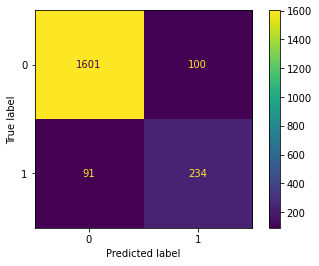

In [60]:
pipe = Pipeline(steps=[('reduce_dim', PCA()),
            ("classify", LGBMClassifier(max_depth=5, random_state=42)),])
N_FEATURES_OPTIONS = [0.9, 0.95]
param_grid = {'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__penalty':['l2','l1'],
        'classify__C':[0.01,0.1,0.5,1]}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_logistic = grid_result.predict(X_test_scaled)
print('Using PCA, Logistic Regression Test Accuracy is {}'.format(accuracy_score(y_test, pred_logistic)))
print("Using PCA, Logistic Regression AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_logistic))
logistic_cm = confusion_matrix(y_test, pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=logistic_cm)
disp.plot()
plt.show()

#### XGBoost

Fitting 5 folds for each of 18 candidates, totalling 90 fits
best score:  0.9790534110656903
best params:  {'classify__min_child_weight': 0.5, 'classify__n_estimators': 200, 'reduce_dim__n_components': 0.95}
Using PCA, XGBoost Test Accuracy is 0.8978282329713722
Using PCA, XGBoost AUC on test set: 0.937
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1701
           1       0.67      0.71      0.69       325

    accuracy                           0.90      2026
   macro avg       0.81      0.82      0.82      2026
weighted avg       0.90      0.90      0.90      2026



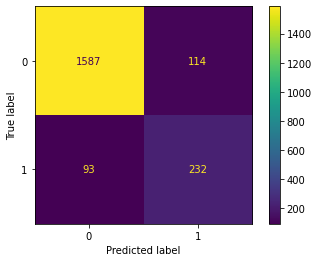

In [61]:
pipe = Pipeline(steps=[('reduce_dim', PCA()),
            ("classify", XGBClassifier(objective='binary:logistic', eval_metric="auc", random_state=42))])
N_FEATURES_OPTIONS = [0.9, 0.95]
param_grid = {'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__n_estimators':[100, 150, 200],
        'classify__min_child_weight':[0.5, 1, 2]
        }
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_xgboost = grid_result.predict(X_test_scaled)
print('Using PCA, XGBoost Test Accuracy is {}'.format(accuracy_score(y_test, pred_xgboost)))
print("Using PCA, XGBoost AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_xgboost))
xgboost_cm = confusion_matrix(y_test, pred_xgboost)
disp = ConfusionMatrixDisplay(confusion_matrix=xgboost_cm)
disp.plot()
plt.show()

#### LightGBM

Fitting 5 folds for each of 54 candidates, totalling 270 fits
best score:  0.9873405713849
best params:  {'classify__learning_rate': 0.1, 'classify__max_depth': 8, 'classify__num_leaves': 50, 'reduce_dim__n_components': 0.9}
Using PCA, LightGBM Test Accuracy is 0.9111549851924975
Using PCA, LightGBM AUC on test set: 0.952
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1701
           1       0.70      0.77      0.74       325

    accuracy                           0.91      2026
   macro avg       0.83      0.85      0.84      2026
weighted avg       0.92      0.91      0.91      2026



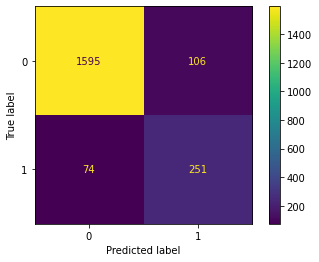

In [62]:
pipe = Pipeline(steps=[('reduce_dim', PCA(n_components=0.90)),
            ("classify", LGBMClassifier(objective = 'binary', metric = 'binary_logloss,auc',random_state=42))])
N_FEATURES_OPTIONS = [0.9, 0.95]
param_grid = {'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__max_depth': [4, 6, 8],
        'classify__num_leaves':[30, 40, 50],
        'classify__learning_rate': [0.01, 0.05, 0.1],
        }

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_lightgbm = grid_result.predict(X_test_scaled)
print('Using PCA, LightGBM Test Accuracy is {}'.format(accuracy_score(y_test, pred_lightgbm)))
print("Using PCA, LightGBM AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_lightgbm))
lightgbm_cm = confusion_matrix(y_test, pred_lightgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=lightgbm_cm)
disp.plot()
plt.show()

#### Random Forest

Fitting 5 folds for each of 18 candidates, totalling 90 fits
best score:  0.9879084969338257
best params:  {'classify__max_samples': 0.9, 'classify__n_estimators': 200, 'reduce_dim__n_components': 0.9}
random forest Test Accuracy is 0.9116485686080947
random forest AUC on test set: 0.948
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1701
           1       0.73      0.72      0.72       325

    accuracy                           0.91      2026
   macro avg       0.84      0.83      0.83      2026
weighted avg       0.91      0.91      0.91      2026



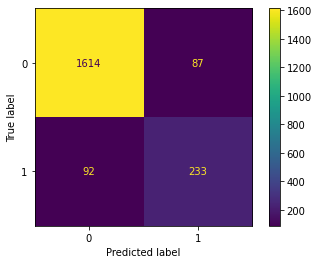

In [63]:
pipe = Pipeline(steps=[('reduce_dim', PCA(n_components=0.90)),
            ("classify", RandomForestClassifier(n_estimators=200, max_features='auto', criterion='entropy', bootstrap=True, random_state=42))])
N_FEATURES_OPTIONS = [0.9, 0.95]
param_grid = {'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__n_estimators':[100, 150, 200],
        'classify__max_samples':[0.1, 0.5, 0.9]
      }
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_rf = grid_result.predict(X_test_scaled)
print('random forest Test Accuracy is {}'.format(accuracy_score(y_test, pred_rf)))
print("random forest AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_rf))
rf_cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
disp.plot()
plt.show()

## 5 Features + Credit_Limit -> Categorical

In [64]:
# Set X & y
X, y = df.iloc[:,1:],df.iloc[:,0]
y = y.apply(lambda x:(x=='Attrited Customer')*1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2048, stratify=y)

In [65]:
def transform(X):
  sic_bins = [1, 2000, 4000, 8000, 20000, 40000]
  X['Credit_Limit'] = pd.cut(X['Credit_Limit'], bins=sic_bins, right=False, include_lowest=True)
  return X

In [66]:
X_train = obtain_new_col(X_train)
X_test = obtain_new_col(X_test)

X_train=transform(X_train)
X_test=transform(X_test)

In [67]:
cat_attri_lst=make_column_selector(dtype_include=[object])(X_train)+['Credit_Limit']
num_attri_lst=set(make_column_selector(dtype_exclude=[object])(X_train))
num_attri_lst.remove('Credit_Limit')
num_attri_lst=list(num_attri_lst)

In [68]:
train_X_dummy=get_dummy(X_train[cat_attri_lst])
test_X_dummy=get_dummy(X_test[cat_attri_lst])

In [69]:
# STD scale
scaler = StandardScaler()

X_train_scaled = pd.concat([pd.DataFrame(scaler.fit_transform(X_train[num_attri_lst])).reset_index(drop=True),train_X_dummy.reset_index(drop=True)],axis=1,ignore_index=True)
X_train_scaled.columns=num_attri_lst+train_X_dummy.columns.to_list()

X_test_scaled = pd.concat([pd.DataFrame(scaler.transform(X_test[num_attri_lst])).reset_index(drop=True),test_X_dummy.reset_index(drop=True)],axis=1,ignore_index=True)
X_test_scaled.columns=num_attri_lst+test_X_dummy.columns.to_list()

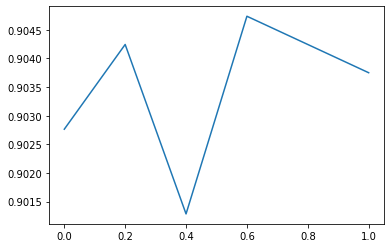

In [70]:
# Resample
cat_col_idx,best_ratio=resample(X_train_scaled,X_test_scaled)
smo = SMOTENC(cat_col_idx,sampling_strategy=best_ratio, random_state=2048)
X_resample, y_resample = smo.fit_resample(X_train_scaled, y_train)

#### Logistic Regression

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best score:  0.9762066386732554
best params:  {'C': 1, 'penalty': 'l2'}
Logistic Regression Test Accuracy is 0.9042448173741362
Logistic Regression AUC on test set: 0.927
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1701
           1       0.71      0.68      0.70       325

    accuracy                           0.90      2026
   macro avg       0.82      0.81      0.82      2026
weighted avg       0.90      0.90      0.90      2026



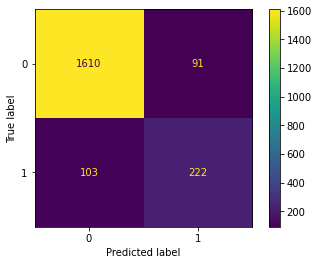

In [71]:
logistic_clf = LogisticRegression(random_state=42)
param_grid = {'penalty':['l2','l1'],
        'C':[0.01,0.1,0.5,1]}
grid = GridSearchCV(logistic_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_logistic = grid_result.predict(X_test_scaled)
print('Logistic Regression Test Accuracy is {}'.format(accuracy_score(y_test, pred_logistic)))
print("Logistic Regression AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_logistic))
logistic_cm = confusion_matrix(y_test, pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=logistic_cm)
disp.plot()
plt.show()

#### XGBoost

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best score:  0.9939372008595893
best params:  {'min_child_weight': 0.5, 'n_estimators': 200}
XGBoost Test Accuracy is 0.9417571569595261
XGBoost AUC on test set: 0.977
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1701
           1       0.81      0.83      0.82       325

    accuracy                           0.94      2026
   macro avg       0.89      0.90      0.89      2026
weighted avg       0.94      0.94      0.94      2026



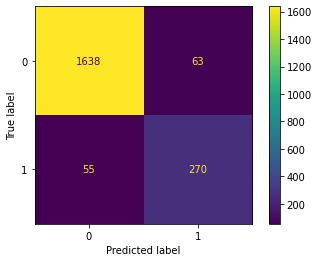

In [72]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_resample.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_resample.columns.values]
X_test_scaled.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_scaled.columns.values]

xgboost_clf = XGBClassifier(objective='binary:logistic', eval_metric="auc", n_jobs=-1 ,random_state=42)
param_grid = {'n_estimators':[100, 150, 200],
        'min_child_weight':[0.5, 1, 2]
        }
grid = GridSearchCV(xgboost_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_xgboost = grid_result.predict(X_test_scaled)
print('XGBoost Test Accuracy is {}'.format(accuracy_score(y_test, pred_xgboost)))
print("XGBoost AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_xgboost))
xgboost_cm = confusion_matrix(y_test, pred_xgboost)
disp = ConfusionMatrixDisplay(confusion_matrix=xgboost_cm)
disp.plot()
plt.show()

#### LightGBM

Fitting 5 folds for each of 27 candidates, totalling 135 fits
best score:  0.9968724630511943
best params:  {'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 50}
LightGBM Test Accuracy is 0.9555774925962488
LightGBM AUC on test set: 0.986
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1701
           1       0.86      0.87      0.86       325

    accuracy                           0.96      2026
   macro avg       0.92      0.92      0.92      2026
weighted avg       0.96      0.96      0.96      2026



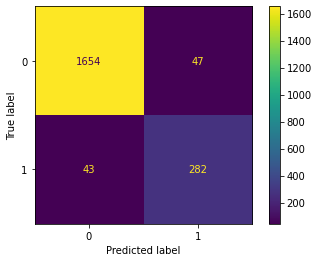

In [73]:
lightgbm_clf = LGBMClassifier(objective = 'binary', metric = 'binary_logloss,auc',random_state=42)

param_grid = {'max_depth': [4, 6, 8],
        'num_leaves':[30, 40, 50],
        'learning_rate': [0.01, 0.05, 0.1],
        }

grid = GridSearchCV(lightgbm_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_lightgbm = grid_result.predict(X_test_scaled)
print('LightGBM Test Accuracy is {}'.format(accuracy_score(y_test, pred_lightgbm)))
print("LightGBM AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_lightgbm))
lightgbm_cm = confusion_matrix(y_test, pred_lightgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=lightgbm_cm)
disp.plot()
plt.show()

##### Feature Importance

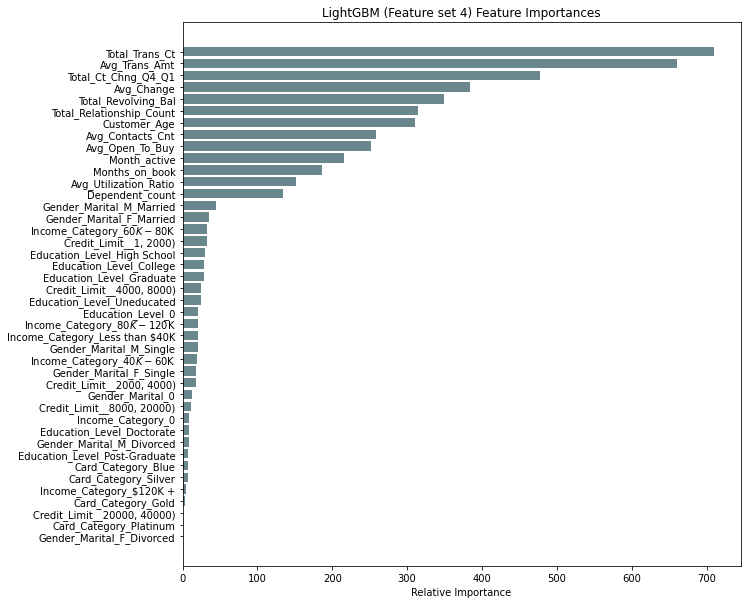

In [74]:
lightgbm_clf = LGBMClassifier(objective = 'binary', metric = 'binary_logloss,auc',random_state=42, learning_rate=0.1, max_depth=8, num_leaves=50)
lightgbm_clf.fit(X_resample, y_resample)
importances = lightgbm_clf.feature_importances_
indices = np.argsort(importances)
features = X_resample.columns.values
lgb_auc = roc_auc_score(y_test,lightgbm_clf.predict_proba(X_test_scaled)[:,1])
plt.figure(figsize=(10,10))
plt.title('LightGBM (Feature set 4) Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#6B878E', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##### Permutation Feature Importance

,pred,score
11,Total_Ct_Chng_Q4_Q1,-0.023937
8,Avg_Trans_Amt,-0.062987
0,Total_Trans_Ct,-0.294462


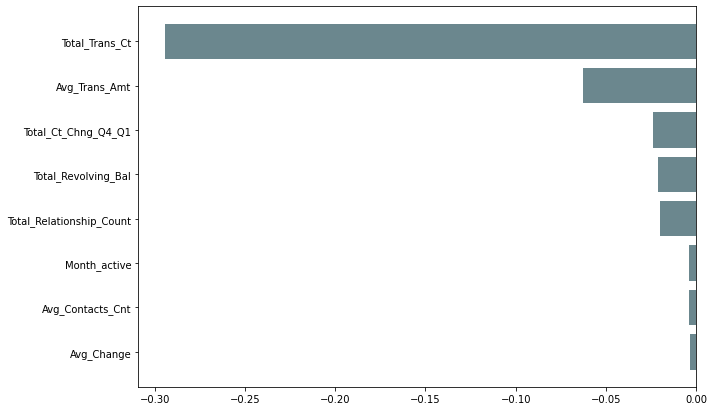

In [75]:
# Initialize a list of results
results = []
# Iterate through each predictor
for predictor in X_test_scaled:
    
    # Create a copy of X_test
    X_test_copy = X_test_scaled.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[predictor] = X_test_scaled[predictor].sample(frac=1).values
    
    # Calculate the new RMSE
    new_auc = roc_auc_score(y_test,lightgbm_clf.predict_proba(X_test_copy)[:,1])
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor, 'score': new_auc - lgb_auc})
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score', ascending = False)
display(resultsdf.tail(3))
X = resultsdf.pred.iloc[-8:]
y = resultsdf.score.iloc[-8:]
plt.figure(figsize=(10,7))
plt.barh(X,y, color='#6B878E')
plt.show()

#### Random Forest

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best score:  0.9954757256224289
best params:  {'max_samples': 0.9, 'n_estimators': 200}
random forest Test Accuracy is 0.9417571569595261
random forest AUC on test set: 0.972
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1701
           1       0.84      0.78      0.81       325

    accuracy                           0.94      2026
   macro avg       0.90      0.88      0.89      2026
weighted avg       0.94      0.94      0.94      2026



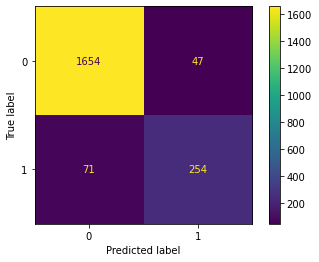

In [76]:
rf_clf = RandomForestClassifier(n_estimators=200, max_features='auto', criterion='entropy', bootstrap=True, random_state=42,)
param_grid = {'n_estimators':[100, 150, 200],
      'max_samples':[0.1, 0.5, 0.9]
      }
grid = GridSearchCV(rf_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_result = grid.fit(X_resample, y_resample)
print('best score: ', grid_result.best_score_)
print('best params: ', grid_result.best_params_)

pred_rf = grid_result.predict(X_test_scaled)
print('random forest Test Accuracy is {}'.format(accuracy_score(y_test, pred_rf)))
print("random forest AUC on test set: {:.3f}".format(roc_auc_score(y_test,grid_result.predict_proba(X_test_scaled)[:,1])))
print(classification_report(y_test, pred_rf))
rf_cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
disp.plot()
plt.show()

#### Deep Learning

In [77]:
NNmodel3 = Sequential()
NNmodel3.add(Dense(units=10, activation='relu', use_bias=True,input_shape=(X_resample.shape[1],)))
NNmodel3.add(Dropout(0.3))
NNmodel3.add(Dense(1, activation='sigmoid'))

NNmodel3.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[tf.keras.metrics.AUC(from_logits=True)])

NNmodel3.fit(X_resample,y_resample,batch_size=256, epochs=100, validation_split=0.2, verbose=1, callbacks=[es])

Epoch 1/100
39/39 [==============================] - 1s 12ms/step - loss: 0.4347 - auc_2: 0.8624 - val_loss: 0.2777 - val_auc_2: 0.0000e+00
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.3156 - auc_2: 0.9227 - val_loss: 0.2698 - val_auc_2: 0.0000e+00
Epoch 3/100
39/39 [==============================] - 0s 4ms/step - loss: 0.2828 - auc_2: 0.9345 - val_loss: 0.1768 - val_auc_2: 0.0000e+00
Epoch 4/100
39/39 [==============================] - 0s 4ms/step - loss: 0.2688 - auc_2: 0.9419 - val_loss: 0.1019 - val_auc_2: 0.0000e+00
Epoch 5/100
39/39 [==============================] - 0s 4ms/step - loss: 0.2621 - auc_2: 0.9454 - val_loss: 0.1675 - val_auc_2: 0.0000e+00
Epoch 6/100
39/39 [==============================] - 0s 4ms/step - loss: 0.2537 - auc_2: 0.9492 - val_loss: 0.1773 - val_auc_2: 0.0000e+00
Epoch 7/100
39/39 [==============================] - 0s 4ms/step - loss: 0.2436 - auc_2: 0.9516 - val_loss: 0.1457 - val_auc_2: 0.0000e+00
Epoch 8/100
39/39 [=======

In [78]:
y_pred=NNmodel3.predict(X_test_scaled)

lst=[]
for i,v in enumerate(y_pred):
  lst.append(int(round(v[0])))
  
y_pred=lst
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1766
           1       0.64      0.80      0.71       260

    accuracy                           0.92      2026
   macro avg       0.81      0.87      0.83      2026
weighted avg       0.93      0.92      0.92      2026

